In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [3]:
 train = pd.read_parquet("/content/16eac85914e04a167f656392c2850aac197133366a5d953a9499702e5360d7a4")

In [5]:
test = pd.read_parquet("/content/df1dafd7a13176813587af8ca6367f723827be4a93522907e443925340f4e445")

In [6]:
train.head()

,Annotation_action,Article_ID,Author,Content,Corrected_label,Date_posted,Link,Prediction,Prediction_prob,Preprocessed_text,Rescaled_prediction_prob,Source,Text,Title,Type,__index_level_0__
0,Don't Annotate,2858,None,En un artículo difundido en su sitio personal ...,Fake,2022-03-01,None,Fake,0.632735,artículo difundido sitio personal coordinador...,0.132735,proceso,Source:proceso\n\n Prediction:Fake\n\n Content...,,Tweet,140
1,Don't Annotate,2005,None,"🔴 El líder nacional de Morena, @mario_delgado ...",True,2022-01-19,None,True,0.441359,líder nacional Morena @mario_delgado llamar I...,0.058641,Excelsior,Source:Excelsior\n\n Prediction:True\n\n Conte...,,Tweet,164
2,Annotate,453,None,NUEVA YORK.- Ben Simmons aseguró el martes qu...,Fake,None,https://vanguardia.com.mx/deportes/ben-simmons...,Fake,0.564037,YORK.- Ben Simmons martes problema mental inic...,0.064037,La Vanguardia,Source:La Vanguardia\n\n Prediction:Fake\n\n C...,Ben Simmons da ‘su verdad’ sobre su salida de ...,Web Article,1449
3,Don't Annotate,590,None,Un estudio realizado por la empresa tecnológi...,True,None,http://www.elnuevosiglo.com.co/articulos/02-14...,Fake,0.584732,estudio empresa tecnológico gamificación Nawai...,0.084732,El Nuevo Siglo,Source:El Nuevo Siglo\n\n Prediction:Fake\n\n ...,Destacan habilidades profesionales de perfiles...,Web Article,29
4,Don't Annotate,1008,None,\nLa Subcomisión Política leyó ayer públic...,True,2020-07-28,https://diario.elmundo.sv/Política/subcomision...,True,0.357733,Subcomisión Política leer públicamente informe...,0.142267,El Mundo,Source:El Mundo\n\n Prediction:True\n\n Conten...,Subcomisión avaló las 75 candidaturas a la C...,Web Article,65


In [7]:
test.head()

,Annotation_action,Article_ID,Author,Content,Corrected_label,Date_posted,Link,Prediction,Prediction_prob,Preprocessed_text,Rescaled_prediction_prob,Source,Text,Title,Type,__index_level_0__
0,Don't Annotate,636,None,"\n\n\r\nMalcolm Cartagena, capacitador del Tri...",True,2017-12-30,https://diario.elmundo.sv/Política/resuelve-tu...,True,0.410082,Malcolm Cartagena capacitador Tribunal Supremo...,0.089918,El Mundo,Source:El Mundo\n\n Prediction:True\n\n Conten...,Resuelve tus dudas sobre las JRV en 12 preguntas,Web Article,1593
1,Don't Annotate,536,None,\n\n\r\nLa Comisión Especial Electoral del FM...,True,2019-06-21,https://diario.elmundo.sv/Política/cce-declara...,Fake,0.575066,Comisión Especial Electoral FMLN declarar maña...,0.075066,El Mundo,Source:El Mundo\n\n Prediction:Fake\n\n Conten...,CEE declara a Ortiz como nuevo secretario gene...,Web Article,1486
2,Don't Annotate,2184,None,Tras el el enfrentamiento entre simpatizantes ...,True,2018-04-01,None,Fake,0.564037,enfrentamiento simpatizante PRD Morena previo ...,0.064037,SinEmbargoMX,Source:SinEmbargoMX\n\n Prediction:Fake\n\n Co...,,Tweet,532
3,Don't Annotate,2914,None,La @Coparmex advirtió que a la @CFEmx le urge ...,Fake,2021-12-10,None,Fake,0.649744,@coparmex advertir @cfemx urge reestructura fi...,0.149744,proceso,Source:proceso\n\n Prediction:Fake\n\n Content...,,Tweet,1153
4,Annotate,261,None,"\nMichelle Sol, alcaldesa de Nuevo Cuscatlán....",True,2019-05-10,https://diario.elmundo.sv/Política/michelle-so...,True,0.462732,Michelle Sol alcaldesa Cuscatlán alcaldesa Cus...,0.037268,El Mundo,Source:El Mundo\n\n Prediction:True\n\n Conten...,Michelle Sol depondrá cargo en alcaldía tras...,Web Article,132


In [8]:
test.shape

(310, 16)

In [9]:
train.shape

(2782, 16)

In [10]:
train["Content"].tolist()

['En un artículo difundido en su sitio personal , el coordinador de Morena en el Senado señaló que este escenario de pugna interna pone en riesgo la Cuarta Transformación de persistir los “comportamientos facciosos y autodestructivos”. https://t.co/s2g6gfcjEk',
 '🔴 El líder nacional de Morena, @mario_delgado llamó al #INE a que convoque al proceso de Revocación de Mandato y deje atrás lo que calificó como “pretextos burocráticos”. https://t.co/DN6ddMz8XC',
 'NUEVA YORK.- Ben Simmons aseguró el martes que sus problemas mentales iniciaron mucho antes del final de la temporada pasada con los 76ers y que no creía que los superaría siguiendo en Filadelfia.\nEl escolta se declaró entusiasmado de continuar con los Nets de Brooklyn, aunque no sabe cuándo podrá debutar con ellos.\nLa ex primera selección del draft no ha jugado desde que los 76ers perdieron ante Atlanta en el séptimo juego de las semifinales de la Conferencia Este.\n“Fue antes de la serie o incluso antes de la temporada 

In [11]:
 text = ' '.join(str(train["Content"].tolist()))

In [12]:
counts = train["Content"].sample(frac=.07).value_counts()

In [13]:
counts

Pablo Casado y Santiago Abascal conversan en el Congreso de los Diputados.\nEFE (ARCHIVO 2019) EXPANSIONNo se puede negar que el PP ha ganado las elecciones autonómicas en Castilla y León y que el PSOE, Ciudadanos y Unidas Podemos las han perdido.\nPero el verdadero vencedor de los comicios ha sido Vox, que se consolida como tercera fuerza política en l                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [14]:
counts.index = counts.index.map(str)


In [ ]:
#wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(counts)
#plt.figure(figsize=(100, 100))
#plt.imshow(wordcloud, interpolation="bilinear")
#plt.axis("off")
#plt.show(wordcloud)
 

In [15]:
test["Content"].tolist()

['\n\n\r\nMalcolm Cartagena, capacitador del Tribunal Supremo Electoral (TSE), resuelve en 12 preguntas las dudas más comunes de los ciudadanos elegidos por sorteo para la conformación de las Juntas Receptoras de Votos (JRV), sobre las excepciones, las excusas, la forma de notificación, de pago, etcétera.\n\n1. ¿Por qué el sorteo?\r\nPorque los partidos no lograron completar sus listados con las personas no afiliadas que les exigía la sentencia de la Sala de lo Constitucional. Por ello hubo que elegir por medio de un sorteo aleatorio a un poco más de 28 mil personas a nivel nacional. Estas han sido seleccionadas en cada sector de votación, con lo que, si usted resulta sorteado, lo más seguro es que le tocará integrar una JRV en el centro de votación donde le habría tocado votar.\n\n2. ¿Qué pasa si salgo sorteado y no quiero estar en una JRV?\r\nComo pasa con cualquier otra violación, la ley contempla una multa que va desde los $25 a los $114, dependiendo del cargo y su co

In [16]:
 text = ' '.join(str(test["Content"].tolist()))

In [17]:
counts = test["Content"].sample(frac=.07).value_counts()

In [18]:
counts

93 mil 810 ejecutados | López Obrador llega a la mitad del sexenio con un país repleto de muerte y violencia\r\nhttps://t.co/NkrFafemxN https://t.co/7zePslMMAe                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [ ]:
#wordcloud = WordCloud(width=1600, height=800).generate_from_frequencies(counts)
#plt.figure(figsize=(100, 100))
#plt.imshow(wordcloud, interpolation="bilinear")
#plt.axis("off")
#plt.show()

In [19]:
test["Content"] = test["Title"] + ' ' + test['Content']
train["Content"] = train["Title"] + ' ' + train['Content']

In [20]:
test["Content"] = test["Content"].apply(lambda x: str(x).lower())
train["Content"] = train["Content"].apply(lambda x: str(x).lower())

In [21]:
test['class'] = 0
train['class'] = 1

In [22]:
test.columns

Index(['Annotation_action', 'Article_ID', 'Author', 'Content',
       'Corrected_label', 'Date_posted', 'Link', 'Prediction',
       'Prediction_prob', 'Preprocessed_text', 'Rescaled_prediction_prob',
       'Source', 'Text', 'Title', 'Type', '__index_level_0__', 'class'],
      dtype='object')

In [23]:
train.columns

Index(['Annotation_action', 'Article_ID', 'Author', 'Content',
       'Corrected_label', 'Date_posted', 'Link', 'Prediction',
       'Prediction_prob', 'Preprocessed_text', 'Rescaled_prediction_prob',
       'Source', 'Text', 'Title', 'Type', '__index_level_0__', 'class'],
      dtype='object')

In [24]:
test = test[["Content", "class"]]
train = train[["Content", "class"]]

In [25]:
test.head(10)

,Content,class
0,resuelve tus dudas sobre las jrv en 12 pregunt...,0
1,cee declara a ortiz como nuevo secretario gene...,0
2,tras el el enfrentamiento entre simpatizantes...,0
3,la @coparmex advirtió que a la @cfemx le urge...,0
4,michelle sol depondrá cargo en alcaldía tras...,0
5,.@lopezobrador_ agregó que sus opositores en ...,0
6,alberto quiere inventar un ministerio para pé...,0
7,csj ordena juicio a expresidente del bmi y exv...,0
8,canadá reduce controles contra el covid en la...,0
9,hrw acusa a bukele de socavar las bases democr...,0


In [26]:
train.head(10)

,Content,class
0,en un artículo difundido en su sitio personal...,1
1,"🔴 el líder nacional de morena, @mario_delgado...",1
2,ben simmons da ‘su verdad’ sobre su salida de ...,1
3,destacan habilidades profesionales de perfiles...,1
4,subcomisión avaló las 75 candidaturas a la c...,1
5,la senadora del pan inscribió un punto de acu...,1
6,cronología de la crisis política del gobierno...,1
7,"""ahora tenemos ya un populista: el señor buke...",1
8,la conferencia mañanera de amlo (270821) http...,1
9,"el expresidente de colombia, juan manuel sant...",1


In [27]:
data = test.append(train, ignore_index=True)

In [28]:
data.sample(10)

,Content,class
1155,voto por rostro para alcaldes desde 2021 \ncon...,1
2186,"aunque todavía no se hace oficial, fue el pre...",1
1887,el ine ha tirado 3 candidaturas a gobernador ...,1
344,"“es ‘nosotros’, no ‘yo’” | amlo dice que monr...",1
2916,@danybarragang @romiinagandara 🔴 #envivo | #...,1
749,"“cambio de personas, no de modelo”, relevos e...",1
2431,amlo habla del caso lozoya: “se debe castigar...,1
2126,piden indagar nexos de líder del prd en guerr...,1
819,"el presidente mexicano, andrés manuel lópez o...",1
1651,leve recuperación de ingresos en agencias de ...,1


In [29]:
!pip install spacy==2.2.3
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4==4.9.1
!pip install textblob==0.15.3

     |████████████████████████████████| 10.4 MB 4.8 MB/s 
     |████████████████████████████████| 2.2 MB 27.4 MB/s 
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 12.0 MB 5.4 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
     |████████████████████████████████| 115 kB 5.4 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [30]:
pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-d13js4dp
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-d13js4dp
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=11756 sha256=9879b79cd590c9f36e5256ef4d853fdf19439d60ba8fe75d4d7322cc50de7702
  Stored in directory: /tmp/pip-ephem-wheel-cache-02is2prg/wheels/0d/b3/29/bfe3deffda68980088d17b81331be6667e837ffb4a071bae82
Successfully built preprocess-kgptalkie


In [31]:
import preprocess_kgptalkie as ps


In [32]:
data["Content"].apply(lambda x: ps.remove_special_chars(x))

0       resuelve tus dudas sobre las jrv en 12 pregunt...
1       cee declara a ortiz como nuevo secretario gene...
2       tras el el enfrentamiento entre simpatizantes ...
3       la coparmex advirtió que a la cfemx le urge un...
4       michelle sol depondra cargo en alcaldia tras s...
                              ...                        
3087    los exmandatarios consideraron que aguascalien...
3088    lo mas importante es mostrar resultado del pla...
3089    opinión es pertinente dejar claro que este eje...
3090    la policía nacional civil realizó el martes un...
3091    opinión jaime garcía chávez jgarciachavezamlo ...
Name: Content, Length: 3092, dtype: object

In [33]:
data.head()

,Content,class
0,resuelve tus dudas sobre las jrv en 12 pregunt...,0
1,cee declara a ortiz como nuevo secretario gene...,0
2,tras el el enfrentamiento entre simpatizantes...,0
3,la @coparmex advirtió que a la @cfemx le urge...,0
4,michelle sol depondrá cargo en alcaldía tras...,0


In [34]:
!pip install gensim==3.8.3

     |████████████████████████████████| 24.2 MB 1.6 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [35]:
import gensim

In [36]:
y = data['class'].values

In [37]:
data['Content'].tolist()

['resuelve tus dudas sobre las jrv en 12 preguntas \n\n\r\nmalcolm cartagena, capacitador del tribunal supremo electoral (tse), resuelve en 12 preguntas las dudas más comunes de los ciudadanos elegidos por sorteo para la conformación de las juntas receptoras de votos (jrv), sobre las excepciones, las excusas, la forma de notificación, de pago, etcétera.\n\n1. ¿por qué el sorteo?\r\nporque los partidos no lograron completar sus listados con las personas no afiliadas que les exigía la sentencia de la sala de lo constitucional. por ello hubo que elegir por medio de un sorteo aleatorio a un poco más de 28 mil personas a nivel nacional. estas han sido seleccionadas en cada sector de votación, con lo que, si usted resulta sorteado, lo más seguro es que le tocará integrar una jrv en el centro de votación donde le habría tocado votar.\n\n2. ¿qué pasa si salgo sorteado y no quiero estar en una jrv?\r\ncomo pasa con cualquier otra violación, la ley contempla una multa que va desde 

In [38]:
x = [i.split() for i in data["Content"].tolist()]

In [39]:
print(x)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [40]:
type(x)

list

In [41]:
print(x[0])

['resuelve', 'tus', 'dudas', 'sobre', 'las', 'jrv', 'en', '12', 'preguntas', 'malcolm', 'cartagena,', 'capacitador', 'del', 'tribunal', 'supremo', 'electoral', '(tse),', 'resuelve', 'en', '12', 'preguntas', 'las', 'dudas', 'más', 'comunes', 'de', 'los', 'ciudadanos', 'elegidos', 'por', 'sorteo', 'para', 'la', 'conformación', 'de', 'las', 'juntas', 'receptoras', 'de', 'votos', '(jrv),', 'sobre', 'las', 'excepciones,', 'las', 'excusas,', 'la', 'forma', 'de', 'notificación,', 'de', 'pago,', 'etcétera.', '1.', '¿por', 'qué', 'el', 'sorteo?', 'porque', 'los', 'partidos', 'no', 'lograron', 'completar', 'sus', 'listados', 'con', 'las', 'personas', 'no', 'afiliadas', 'que', 'les', 'exigía', 'la', 'sentencia', 'de', 'la', 'sala', 'de', 'lo', 'constitucional.', 'por', 'ello', 'hubo', 'que', 'elegir', 'por', 'medio', 'de', 'un', 'sorteo', 'aleatorio', 'a', 'un', 'poco', 'más', 'de', '28', 'mil', 'personas', 'a', 'nivel', 'nacional.', 'estas', 'han', 'sido', 'seleccionadas', 'en', 'cada', '

In [42]:
Dimension = 100
word_2_vec = gensim.models.Word2Vec(sentences=x, size=Dimension, window=10, min_count=1)


In [43]:
len(word_2_vec.wv.vocab)

51814

In [44]:
word_2_vec.wv.vocab

{'resuelve': <gensim.models.keyedvectors.Vocab at 0x7f422649aad0>,
 'tus': <gensim.models.keyedvectors.Vocab at 0x7f422644e290>,
 'dudas': <gensim.models.keyedvectors.Vocab at 0x7f4224517e50>,
 'sobre': <gensim.models.keyedvectors.Vocab at 0x7f4224517f10>,
 'las': <gensim.models.keyedvectors.Vocab at 0x7f4224517d50>,
 'jrv': <gensim.models.keyedvectors.Vocab at 0x7f4224520150>,
 'en': <gensim.models.keyedvectors.Vocab at 0x7f4224520990>,
 '12': <gensim.models.keyedvectors.Vocab at 0x7f4224520950>,
 'preguntas': <gensim.models.keyedvectors.Vocab at 0x7f4224517e90>,
 'malcolm': <gensim.models.keyedvectors.Vocab at 0x7f4224520890>,
 'cartagena,': <gensim.models.keyedvectors.Vocab at 0x7f4224520850>,
 'capacitador': <gensim.models.keyedvectors.Vocab at 0x7f4224520a10>,
 'del': <gensim.models.keyedvectors.Vocab at 0x7f4224520a50>,
 'tribunal': <gensim.models.keyedvectors.Vocab at 0x7f4224518810>,
 'supremo': <gensim.models.keyedvectors.Vocab at 0x7f4224518890>,
 'electoral': <gensim.models.

In [45]:
word_2_vec['gobiernos']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 0.40352416,  0.18400042, -0.1396371 , -0.575765  , -0.44377944,
        0.13766432, -0.8994178 ,  0.04234945, -0.6934781 , -0.0072603 ,
       -0.41337746, -0.68581873,  0.18624094,  0.03037049, -0.3706153 ,
        0.4743063 , -0.2541634 , -0.28133914, -0.35138   , -0.428802  ,
       -0.7477365 ,  0.04874508,  0.6711502 , -0.6334966 , -0.50749165,
        0.455395  , -0.5432235 , -0.215842  , -0.15418494,  0.24897783,
       -0.3457774 , -0.60904086, -0.24031764, -0.31473735,  0.12720066,
       -0.11558451, -0.4606136 ,  0.20099139,  0.2989358 ,  0.33821687,
        0.17841324,  0.18386348,  0.02266629, -0.13117807, -0.16982432,
        0.20671509,  0.26823664, -0.20462897, -0.01136309,  0.20550412,
       -0.12230586,  0.24205351,  0.05950979, -0.09584418,  0.2651478 ,
       -0.18157716,  1.1498625 , -0.55104154, -0.01870666, -0.3309894 ,
       -0.34686717,  0.0700089 , -0.2795777 ,  0.20690164,  0.17559011,
        0.6157039 ,  0.07090907,  0.0180176 , -0.26096246, -0.13

In [46]:
word_2_vec.wv.most_similar('gobiernos')

[('reitera', 0.998699426651001),
 ('aliados', 0.9986109137535095),
 ('reuniones', 0.998603343963623),
 ('manifestantes', 0.9983799457550049),
 ('realizaron', 0.9983182549476624),
 ('residentes', 0.998196542263031),
 ('cifras', 0.9981372356414795),
 ('mensajes', 0.9980984330177307),
 ('acciones', 0.9980980157852173),
 ('ocho', 0.9979521632194519)]

In [47]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)

In [48]:
X = tokenizer.texts_to_sequences(x)

In [49]:
tokenizer.word_index

{'de': 1,
 'la': 2,
 'el': 3,
 'que': 4,
 'en': 5,
 'a': 6,
 'y': 7,
 'los': 8,
 'del': 9,
 'para': 10,
 'por': 11,
 'se': 12,
 'las': 13,
 'no': 14,
 'con': 15,
 'un': 16,
 'una': 17,
 'es': 18,
 'al': 19,
 'su': 20,
 'lo': 21,
 'como': 22,
 'presidente': 23,
 'ha': 24,
 'este': 25,
 'más': 26,
 'o': 27,
 'sus': 28,
 'asamblea': 29,
 'gobierno': 30,
 'fue': 31,
 'ley': 32,
 'pero': 33,
 'partido': 34,
 'sobre': 35,
 'le': 36,
 'dijo': 37,
 'si': 38,
 'está': 39,
 'contra': 40,
 'hay': 41,
 'esta': 42,
 'ya': 43,
 'nacional': 44,
 'también': 45,
 'salvador': 46,
 'sin': 47,
 'han': 48,
 'son': 49,
 'diputados': 50,
 'tiene': 51,
 'ser': 52,
 'entre': 53,
 'porque': 54,
 'comisión': 55,
 'diputado': 56,
 'estados': 57,
 'millones': 58,
 'legislativa': 59,
 'personas': 60,
 'sala': 61,
 'general': 62,
 'desde': 63,
 'están': 64,
 'acuerdo': 65,
 'estado': 66,
 'puede': 67,
 'fmln': 68,
 'partidos': 69,
 'ese': 70,
 'dos': 71,
 'bukele': 72,
 'electoral': 73,
 'hasta': 74,
 'aseguró

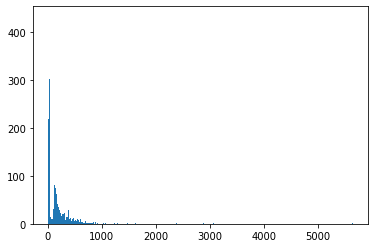

In [50]:
plt.hist([len(x) for x in X], bins=700)
plt.show()

In [51]:
nos = np.array([len(x) for x in X])
len(nos[nos>1000])


18

In [52]:
maxlen = 500
x = pad_sequences(X, maxlen=maxlen)

In [53]:
len(x[0])

500

In [54]:
len(x[3])

500

In [55]:
vocab_size = len(tokenizer.word_index) + 1
vocab = tokenizer.word_index

In [56]:
def get_weight_metrics(model):
  weight_matrix = np.zeros((vocab_size, Dimension))

  for word, i in vocab.items():
    weight_matrix[i] = word_2_vec.wv[word]

  return weight_matrix
   

In [57]:
embedding_vectors = get_weight_metrics(word_2_vec.wv)

In [58]:
embedding_vectors.shape

(51815, 100)

In [59]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [60]:
from tensorflow.keras.callbacks import TensorBoard
import time

In [61]:

Name = 'Fake News Detector-{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(Name))

In [62]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim = Dimension, weights = [embedding_vectors], input_length = maxlen, trainable = False))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [63]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          5181500   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 5,298,877
Trainable params: 117,377
Non-trainable params: 5,181,500
_________________________________________________________________


In [64]:
x.shape

(3092, 500)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(x, y)

In [66]:
type(X_train),type(y_train),X_train.shape

(numpy.ndarray, numpy.ndarray, (2319, 500))

In [67]:
model.fit(X_train, y_train, validation_split=0.3, epochs=300, callbacks=[tensorboard])

Epoch 1/300
51/51 [==============================] - 12s 115ms/step - loss: 0.3604 - acc: 0.8799 - val_loss: 0.3030 - val_acc: 0.9109
Epoch 2/300
51/51 [==============================] - 5s 95ms/step - loss: 0.3431 - acc: 0.8928 - val_loss: 0.3054 - val_acc: 0.9109
Epoch 3/300
51/51 [==============================] - 5s 95ms/step - loss: 0.3418 - acc: 0.8928 - val_loss: 0.3043 - val_acc: 0.9109
Epoch 4/300
51/51 [==============================] - 5s 95ms/step - loss: 0.3393 - acc: 0.8928 - val_loss: 0.3022 - val_acc: 0.9109
Epoch 5/300
51/51 [==============================] - 5s 98ms/step - loss: 0.3412 - acc: 0.8928 - val_loss: 0.3043 - val_acc: 0.9109
Epoch 6/300
51/51 [==============================] - 5s 94ms/step - loss: 0.3434 - acc: 0.8928 - val_loss: 0.3050 - val_acc: 0.9109
Epoch 7/300
51/51 [==============================] - 5s 94ms/step - loss: 0.3429 - acc: 0.8928 - val_loss: 0.3014 - val_acc: 0.9109
Epoch 8/300
51/51 [==============================] - 5s 95ms/step - loss: 

In [68]:
y_pred = (model.predict(X_test) >= 0.5).astype(int)

In [69]:
accuracy_score(y_test, y_pred)

0.8680465717981889

In [70]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.15      0.08      0.11        74
           1       0.91      0.95      0.93       699

    accuracy                           0.87       773
   macro avg       0.53      0.52      0.52       773
weighted avg       0.83      0.87      0.85       773



In [71]:
#Code used to test other texts if you want to know whether they are fake / real
#An example is provided below for testing

x = ['Hoy el gobierno colombiano hizo cambios a la ley de inmigración']
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x, maxlen=maxlen)

In [72]:
#Our model predicted the above sentence as being true
(model.predict(x) >= 0.5).astype(int)

array([[0]])

In [73]:
!pip install tensorboard

In [74]:
from tensorflow.keras.callbacks import TensorBoard
import time

In [ ]:
#How to run this model in Tensorboard
#Create a logs folder on your system
#In the folders tab in Colab, download the events files after running the model
#Save the event files to your logs folder
#In a command terminal write the following commands: tensorboard --logdir=logs
#After that, tensorboard will provide a url
#Copy the url into a new tab to see the metrics
